# Домашнее задание № 5

Сегодня мы будем  своими руками реализовывать градиентный бустинг на основе вычисления Lambda!

В качестве базового алгоритма для бустинга будем использовать ```DecisionTreeRegressor``` из библиотеки ```sklearn```. Как было сказано в лекции, единственное существенное отличие — это целевые метки, на которые обучается каждое дерево: вместо типичных для бустинга ошибок (невязок) используются Lambda-значения. Функцию вычисления лямбд мы рассмотрели на практическом занятии. В решение необходимо осмысленно перенести реализацию в метод ```_compute_lambdas``` класса ```Solution```.

## Параметры класса
```n_estimators``` — количество деревьев, которые будут строиться в рамках бустинга.

```lr``` — Learning Rate, коэффициент, на который умножаются предсказания каждого нового дерева в алгоритме (каждое дерево учится предсказывать значение lambda, но не факт, что добавление к текущим предсказаниям такого значения даст оптимум, поэтому весь “путь” оптимизации разбивается на маленькие шаги).

```subsample``` — доля объектов от выборки, на которых обучается каждое дерево (доля одинакова для всех деревьев, но сама подвыборка генерируется на каждом шаге отдельно).

```colsample_bytree``` — доля признаков от выборки, на которых обучается каждое дерево (доля одинакова для всех деревьев, но сама подвыборка генерируется на каждом шаге отдельно).

Совокупность двух вышеуказанных параметров позволяет реализовать метод случайных подпространств (смотрите описание по ссылке при необходимости). ✅🚸🚸 Понятно, что для применения деревьев (получения предсказания) нужно хранить индексы использованных признаков (но не объектов).

```max_depth``` и ```min_samples_leaf``` — параметры ```DecisionTreeRegressor```, отвечающие за глубину построения дерева и минимальное количество в терминальных (финальных) листьях дерева соответственно.

## Методы класса
```_get_data```, ```_prepare_data```, ```_scale_features_in_query_groups```, ```_ndcg_k``` уже знакомы — можно перенести их реализацию  с тем лишь отличием, что для удобства срезов по индексам размерности ```ys_train``` и ```ys_test``` должны быть 💢N∗1, где N-количество объектов (без этого грейдер будет отчитываться об ошибке).

```save_model``` и ```load_model``` — методы, отвечающие за сохранение и загрузку модели. Вам необходимо самостоятельно определить набор полей (их минимум 3), которые нужно сохранять после тренировки и загружать для предсказания. После ```load_model``` необходимо добиться, чтобы модель могла давать те же самые предсказания, что и до сохранения. Сохранение и загрузку реализуйте через модуль ```pickle```. Пример:

```bash
state = {…}
f = open(path, 'wb')
pickle.dump(state, f)
```

Предсказания формируются в методе ```predict```. На вход поступает тензор данных размерности N∗D, где N — количество объектов, D — количество признаков. На выходе ожидается применённый алгоритм бустинга, т.е. тензор предсказаний.

Расчёт метрики по набору данных должен производиться методом ```_calc_data_ndcg``` — в нём необходимо проитерироваться по группам запросов, посчитав в каждой ```NDCG```, после чего вернуть усреднённое значение метрики.

## Методы для тренировки
```_train_one_tree``` — метод для тренировки одного дерева. Принимает на вход ```cur_tree_idx``` — номер текущего дерева, ✅который предлагается использовать в качестве random_seed для того, чтобы алгоритм был детерминирован. ```train_preds``` — суммарные предсказания всех предыдущих деревьев (для расчёта лямбд). В рамках метода необходимо рассчитать лямбды для каждой группы в тренировочном наборе данных, затем применить метод случайных подпространств, сделав срез по признакам (случайно выбранная группа, размер которой задан параметром ```colsample_bytree```) и по объектам (тоже случайно выбранная группа, размер зависит от параметра subsample). Затем произвести тренировку одного ```DecisionTreeRegressor```. Возвращаемые значения — это само дерево и индексы признаков, на которых обучалось дерево.

```fit``` — генеральный метод обучения K деревьев, каждое из которых тренируется с использованием метода ```_train_one_tree```. Изначальные предсказания до обучения предлагается приравнять к нулю и от этих значений отталкиваться при обучении первого дерева. Все обученные деревья необходимо сохранить в список, хранящийся в атрибуте trees класса ```Solution```. 💢Для простоты и ускорения работы предлагается рассчитывать предсказания для всех тренировочных и валидационных данных после обучения каждого дерева (но досчитывать только изменения за последнее дерево, храня в памяти предсказания всех предыдущих). Следите за лучшим значением ```NDCG``` (хранить в переменной ```best_ndcg```) — после окончания тренировки нужно обрезать те последние N деревьев, которые лишь ухудшают метрику на валидации. Например, вы обучили 100 деревьев, и лучший результат был достигнут на 78-м. Тогда ```self.trees``` нужно обрезать до 78-го дерева, чтобы модель при предсказании работала лучше всего.

## Критерии оценки
- Корректная предобработка данных.
- Модель адекватно отработала на 1 дереве, ```NDCG``` выше порога случайных предсказаний.
- Модель на 100 деревьев на подложенных данных обучается, ```NDCG≥0.425```.
- Обученная и сохраненная модель после загрузки корректно дала предсказания в методе ```predict```.

 ## imports/seed


In [46]:
# !pip install catboost

In [44]:
import math
import pickle
import random
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from catboost.datasets import msrank_10k
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm.auto import tqdm


def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## Model

In [54]:
class NDCG:
    @staticmethod
    def compute_gain(y_value: float, gain_scheme: str) -> float:
        assert isinstance(y_value, float), f"check y_value type: {type(y_value)}, is not float"

        if gain_scheme == "const":
            return y_value
        elif gain_scheme == "exp2":
            return 2**y_value - 1
        else:
            assert gain_scheme in ["const", "exp2"], f"check gain_scheme: {gain_scheme}"

    @staticmethod
    def dcg(ys_true: torch.Tensor, ys_pred: torch.Tensor, gain_scheme: str, top_k: int = 0) -> float:
        ys_true = ys_true.squeeze()
        ys_pred = ys_pred.squeeze()

        _, argsort = torch.sort(ys_pred, descending=True)
        ys_true_sorted = ys_true[argsort]  # sorted by pred

        if top_k > 0:
            ys_true_sorted = ys_true_sorted[:top_k]

        dcg = float(0)
        for idx, cur_y in enumerate(ys_true_sorted, 1):
            gain = NDCG.compute_gain(float(cur_y.item()), gain_scheme)
            dcg += gain / math.log2(idx + 1)

        return dcg

    @staticmethod
    def ndcg_score(ys_true: torch.Tensor, ys_pred: torch.Tensor, gain_scheme: str = "exp2", top_k: int = 0) -> float:
        return NDCG.dcg(ys_true, ys_pred, gain_scheme, top_k) / NDCG.dcg(ys_true, ys_true, gain_scheme, top_k)


In [97]:
class Solution:
    def __init__(self, n_estimators: int = 100, lr: float = 0.5, ndcg_top_k: int = 10,
                 subsample: float = 0.6, colsample_bytree: float = 0.9,
                 max_depth: int = 5, min_samples_leaf: int = 8):
        self.X_train, self.df_X_train = None, None
        self.ys_train, self.df_ys_train = None, None
        self.X_test, self.df_X_test = None, None
        self.ys_test, self.df_ys_test = None, None

        self._prepare_data()

        self.ndcg_top_k = ndcg_top_k
        self.n_estimators = n_estimators  # количество деревьев
        self.lr = lr  # Learning Rate, коэффициент, на который умножаются предсказания каждого нового дерева
        self.max_depth = max_depth  # максимальная глубина
        self.min_samples_leaf = min_samples_leaf  # минимальное количество термальных листьев

        self.subsample = subsample  # доля объектов от выборки
        self.colsample_bytree = colsample_bytree  # доля признаков от выборки

        self.trees: List[DecisionTreeRegressor] = []  # все деревья
        self.features_idxs = []  # их подвыборка фичей
        self.all_ndcg: List[float] = []
        self.best_ndcg = float(0.0)
        self.best_num_trees = 1

        self.train_predicts = torch.zeros(self.ys_train.shape[0], dtype=float).view(-1,1)
        self.test_predicts = torch.zeros(self.ys_test.shape[0], dtype=float).view(-1,1)


    def _get_data(self) -> List[np.ndarray]:
        train_df, test_df = msrank_10k()

        X_train = train_df.drop([0, 1], axis=1).values
        y_train = train_df[0].values
        query_ids_train = train_df[1].values.astype(int)

        X_test = test_df.drop([0, 1], axis=1).values
        y_test = test_df[0].values
        query_ids_test = test_df[1].values.astype(int)

        return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

    def _prepare_data(self) -> None:
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()
        self.X_train = torch.FloatTensor(self._scale_features_in_query_groups(X_train, self.query_ids_train))
        self.ys_train = torch.FloatTensor(y_train).view(-1,1)

        self.X_test = torch.FloatTensor(self._scale_features_in_query_groups(X_test, self.query_ids_test))
        self.ys_test = torch.FloatTensor(y_test).view(-1,1)

        #  чисто для того, чтобы удобнее было с обучением деревьев
        self.df_X_train = pd.DataFrame(self.X_train)
        self.df_ys_train = pd.DataFrame(self.ys_train)
        self.df_X_test = pd.DataFrame(self.X_test)
        self.df_ys_test = pd.DataFrame(self.ys_test)

    def _scale_features_in_query_groups(self, inp_feat_array: np.ndarray, inp_query_ids: np.ndarray) -> np.ndarray:
        for id in np.unique(inp_query_ids):
            scaler = StandardScaler()
            idxs = inp_query_ids == id
            inp_feat_array[idxs] = scaler.fit_transform(inp_feat_array[idxs])

        return inp_feat_array

    def _train_one_tree(self, cur_tree_idx: int,
                        train_preds: torch.FloatTensor
                        ) -> Tuple[DecisionTreeRegressor, np.ndarray]:
        """
        Метод для тренировки одного дерева.

        @cur_tree_idx: номер текущего дерева, который предлагается использовать в качестве random_seed для того,
        чтобы алгоритм был детерминирован.
        @train_preds: суммарные предсказания всех предыдущих деревьев (для расчёта лямбд).
        @return: это само дерево и индексы признаков, на которых обучалось дерево
        """
        target = torch.zeros(self.ys_train.shape[0], dtype=float).view(-1,1)
        for id in np.unique(self.query_ids_train):
            idxs = self.query_ids_train == id

            # Находим лямбда, на которые будем обучать дерево
            _, _, _, _, lambdas = self._compute_lambdas(self.ys_train[idxs], self.train_predicts[idxs])
            target[idxs] -= lambdas

        # подвыборка фичей
        n_fea = self.df_X_train.shape[1]
        num_to_choice = int(n_fea * self.colsample_bytree)
        features_subsample_idx = np.random.choice(self.df_X_train.columns, num_to_choice, replace=False)
        d3_X_train = self.df_X_train[features_subsample_idx]

        # подвыборка строк выборки
        n_rows = self.df_X_train.shape[0]
        num_to_choice = int(n_rows * self.subsample)
        rows_subsample_idx = np.random.choice(self.df_X_train.index, num_to_choice, replace=False)
        X_train = d3_X_train.iloc[rows_subsample_idx]
        target = pd.DataFrame(target)
        y_train = target.iloc[rows_subsample_idx]

        return DecisionTreeRegressor(max_depth=self.max_depth,
                                     min_samples_leaf=self.min_samples_leaf,
                                     random_state=cur_tree_idx).fit(X_train, y_train), features_subsample_idx


    def _calc_ndcg(self, true, preds, query_list) -> float:
        """ Расчёт метрики по набору данных """
        ndcgs = []
        for id in np.unique(query_list):
            idxs = query_list == id
            score = self._ndcg_k(true[idxs].squeeze(), preds[idxs].squeeze(), self.ndcg_top_k)
            ndcgs.append(score)

        return np.mean(ndcgs)

    def fit(self):
        """
        генеральный метод обучения K деревьев, каждое из которых тренируется
        с использованием метода _train_one_tree
        """
        set_seed(0)
        train_ndcg = []

        for i in tqdm(range(self.n_estimators)):
            current_tree, features_subsample_idx = self._train_one_tree(i, self.train_predicts)
            self.trees.append(current_tree)
            self.features_idxs.append(features_subsample_idx)

            train_pred = torch.tensor(current_tree.predict(self.df_X_train[features_subsample_idx]), dtype=float).view(-1, 1)
            self.train_predicts += self.lr * train_pred
            train_ndcg.append(self._calc_ndcg(self.ys_train, self.train_predicts, self.query_ids_train))

            # validation
            test_pred = torch.tensor(current_tree.predict(self.df_X_test[features_subsample_idx]), dtype=float).view(-1, 1)
            self.test_predicts += self.lr * test_pred

            current_ndcg = self._calc_ndcg(self.ys_test, self.test_predicts, self.query_ids_test)
            self.all_ndcg.append(current_ndcg)
            if current_ndcg > self.best_ndcg:
                self.best_ndcg = current_ndcg
                self.best_num_trees = i+1

        plt.plot(np.arange(self.n_estimators), self.all_ndcg, label='test')
        plt.plot(np.arange(self.n_estimators), train_ndcg, label='train')
        plt.title("ndcg")
        plt.legend()
        print("best ndcg on test:", self.best_ndcg)
        print("optimal number of trees with best ndcg:", self.best_num_trees)
        self.trees = self.trees[: self.best_num_trees]
        self.features_idxs = self.features_idxs[: self.best_num_trees]
        self.save_model("model.pckl")


    def predict(self, data) -> torch.FloatTensor:
        preds = torch.FloatTensor(torch.zeros(data.shape[0], 1))
        data = pd.DataFrame(data)

        for i in tqdm(range(len(self.trees))):
            local_preds = torch.FloatTensor(self.trees[i].predict(data[self.features_idxs[i]])).view(-1, 1)
            preds += self.lr * local_preds

        return preds

#--------------------------------------------------------------------------------------------------------------------------------
    def _compute_lambdas(self, y_true: torch.FloatTensor, y_pred: torch.FloatTensor, ndcg_scheme='exp2') -> torch.FloatTensor:
        # допишите ваш код здесь
        # рассчитаем нормировку, IdealDCG
        ideal_dcg = NDCG.dcg(y_true, y_true, ndcg_scheme)
        N = 1 / (ideal_dcg + 1e-10)

        # рассчитаем порядок документов согласно оценкам релевантности
        _, rank_order = torch.sort(y_true, descending=True, axis=0)
        rank_order += 1

        with torch.no_grad():
            # получаем все попарные разницы скоров в батче
            pos_pairs_score_diff = 1.0 + torch.exp((y_pred - y_pred.t()))

            # поставим разметку для пар, 1 если первый документ релевантнее
            # -1 если второй документ релевантнее
            Sij = self._compute_labels_in_batch(y_true)
            # посчитаем изменение gain из-за перестановок
            gain_diff = self._compute_gain_diff(y_true, ndcg_scheme)

            # посчитаем изменение знаменателей-дискаунтеров
            decay_diff = (1.0 / torch.log2(rank_order + 1.0)) - (1.0 / torch.log2(rank_order.t() + 1.0))
            # посчитаем непосредственное изменение nDCG
            delta_ndcg = torch.abs(N * gain_diff * decay_diff)
            # посчитаем лямбды
            lambda_update =  (0.5 * (1 - Sij) - 1 / pos_pairs_score_diff) * delta_ndcg
            lambda_update = torch.sum(lambda_update, dim=1, keepdim=True)

            return Sij, gain_diff, decay_diff, delta_ndcg, lambda_update

    def _compute_labels_in_batch(self, y_true):
        # разница релевантностей каждого с каждым объектом
        rel_diff = y_true - y_true.t()

        # 1 в этой матрице - объект более релевантен
        pos_pairs = (rel_diff > 0).type(torch.float32)

        # 1 тут - объект менее релевантен
        neg_pairs = (rel_diff < 0).type(torch.float32)
        Sij = pos_pairs - neg_pairs
        return Sij

    def _compute_gain_diff(self, y_true, gain_scheme):
        if gain_scheme == "exp2":
            gain_diff = torch.pow(2.0, y_true) - torch.pow(2.0, y_true.t())
        elif gain_scheme == "diff":
            gain_diff = y_true - y_true.t()
        else:
            raise ValueError(f"{gain_scheme} method not supported")
        return gain_diff
#--------------------------------------------------------------------------------------------------------------------------------

    def _ndcg_k(self, ys_true, ys_pred, ndcg_top_k) -> float:
        try:
            return NDCG.ndcg_score(ys_true, ys_pred, top_k=ndcg_top_k)
        except ZeroDivisionError:
            return float(0)

    def save_model(self, path: str):
        state = {"lr": self.lr, "trees": self.trees, "features_idxs": self.features_idxs}
        with open(path, "wb") as f:
            pickle.dump(state, f)

    def load_model(self, path: str):
        with open(path, "rb") as f:
            loaded_model = pickle.load(f)

        self.lr = loaded_model["lr"]
        self.trees = loaded_model["trees"]
        self.features_idxs = loaded_model["features_idxs"]


# Запуск и сохранение модели

  0%|          | 0/100 [00:00<?, ?it/s]

best ndcg on test: 0.4378616352104588
optimal number of trees with best ndcg: 65


  0%|          | 0/65 [00:00<?, ?it/s]

ndcg predict after loading 0.4378616352104588
sovpalo, raduemsya


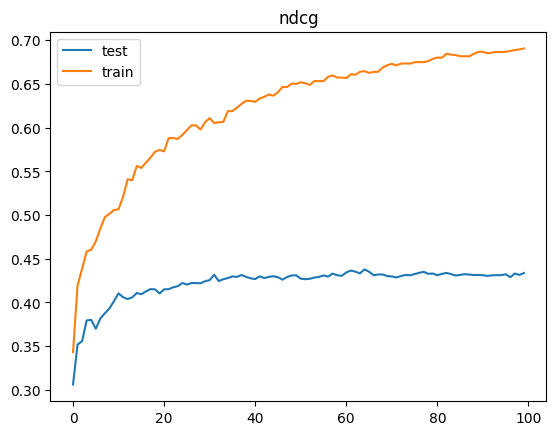

In [101]:
sol = Solution(n_estimators = 100)
sol.fit()

lambda_boosting = Solution()
lambda_boosting.load_model("model.pckl")

# +18 контент, говнокод лютый (чисто чтобы убедиться, что нормально предсказывает)
train_df, test_df = msrank_10k()

X_test = test_df.drop([0, 1], axis=1).values
X_test = torch.FloatTensor(lambda_boosting._scale_features_in_query_groups(X_test, lambda_boosting.query_ids_test))
y_test = test_df[0].values

predicts = lambda_boosting.predict(X_test)
print("ndcg predict after loading", lambda_boosting._calc_ndcg(torch.FloatTensor(y_test).view(-1,1), predicts, lambda_boosting.query_ids_test))
print("sovpalo, raduemsya")


  0%|          | 0/200 [00:00<?, ?it/s]

best ndcg on test: 0.4488113611150799
optimal number of trees with best ndcg: 110


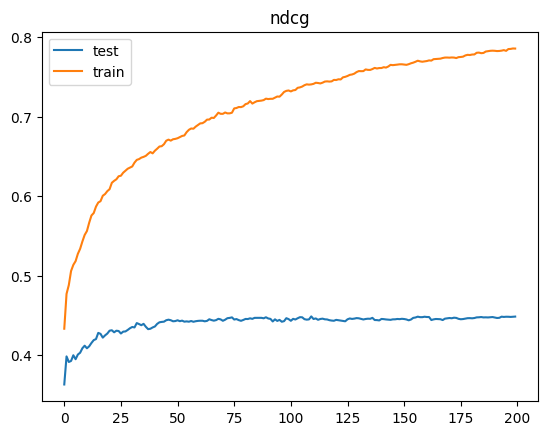

In [86]:
sol = Solution(n_estimators = 200, lr = 0.3, ndcg_top_k = 15,
                 subsample = 0.7, colsample_bytree = 0.9,
                 max_depth = 6, min_samples_leaf = 8)
sol.fit()